In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 1 - Tissue Velocity is Sparse

In [29]:
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

from utils.dataset import *
from utils.decomposition.decomposition_utils import *

transform = Reshape2DField()
vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
runt_dataset = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
eve_dataset = AtlasDataset('WT', 'Even_Skipped', 'velocity2D', transform=transform, drop_time=True)
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 5/5 [00:00<00:00, 311.25it/s]


## Ensemble of cell trajectories

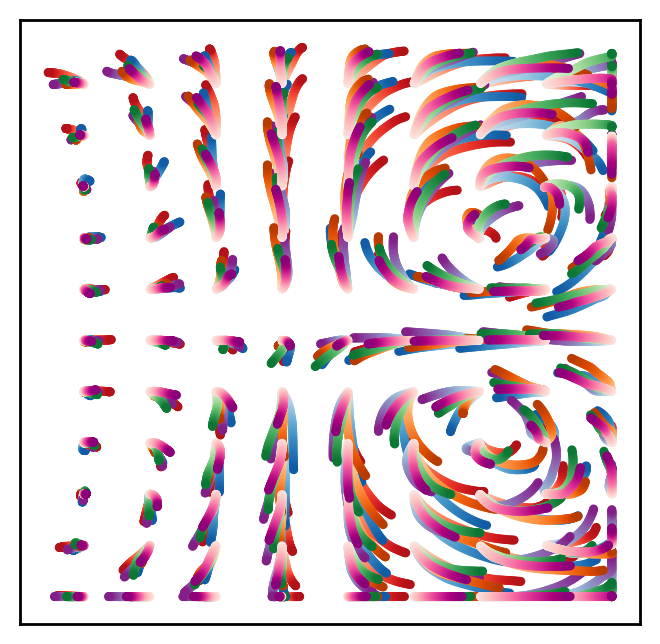

In [30]:
#Demonstrate ensemble of cell trajectories
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['axes.titlesize'] = 8


from math import floor, ceil
from scipy.interpolate import RectBivariateSpline as interp2d

def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

from scipy.io import loadmat
px = loadmat('/project/vitelli/jonathan/fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
X0, Y0 = px['XX'], px['YY']

X0 = X0 * 0.2619 / 0.4 #Convert pixels to microns
Y0 = Y0 * 0.2619 / 0.4 #Convert pixels to microns

X0 = X0[10:-10, 10:-10]
Y0 = Y0[10:-10, 10:-10]

df = vel_dataset.df
df.time = df.time.astype(int)
rows = df[df.time == 30]
tmax = 15

hh = 0.2
sub = 20
pts = np.stack([X0[::-sub, ::-sub].flatten(), 
                Y0[::sub, ::sub].flatten()], axis=-1).reshape([-1, 2])

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4, 4))

cmaps = [
    'Reds',
    'Blues',
    'BuPu',
    'Oranges',
    'Greens',
    'RdPu',
]

for i in range(len(rows)):
    row = rows.iloc[i]
    v = vel_dataset.values[row.embryoID][row.eIdx:row.eIdx+tmax, :, 10:-10, 10:-10]
    xyPathsMat = rk4DynamicVelocity2D(pts, X0[0], Y0[:, 0], v, hh)

    nPts = xyPathsMat.shape[0]
    nTps = xyPathsMat.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(xyPathsMat[:, tpId, 0], xyPathsMat[:, tpId, 1], s=5, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
        
ax.set(xticks=[], yticks=[])
plt.savefig('Figures/EnsembleTrajectories.png', dpi=350, bbox_inches='tight')

## Tissue flow is stereotypic

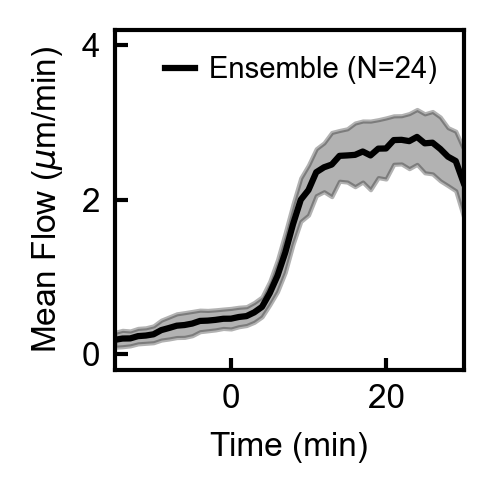

In [76]:
from scipy.stats import sem

plt.style.use('Figure1/Figure1.mplstyle')


fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

df = pd.DataFrame()
N = 0
for dataset in [sqh_dataset, cad_dataset, runt_dataset, eve_dataset, hist_dataset]:
    for eId in dataset.df.embryoID.unique():
        values = dataset.values[eId]
        time = dataset.df.loc[dataset.df.embryoID == eId, 'time']
        eIdx = dataset.df.loc[dataset.df.embryoID == eId, 'eIdx']
        norm = np.linalg.norm(values.reshape([values.shape[0], -1, *values.shape[-2:]]), axis=1).mean(axis=(1, 2))
        if 'Runt' in dataset.label or 'Eve' in dataset.label:
            norm /= 0.2619 / 0.4
        if 'hist' in dataset.label:
            norm *= 0.2619 / 0.4
        df = df.append(pd.DataFrame({
            'time': time.values,
            'v': norm[eIdx.values]
        }), ignore_index=True)
        N += 1

df['time'] = np.round(df.time.values)
df = df.groupby('time')['v'].agg(['mean', sem]).reset_index()

ax.plot(df['time'], df['mean'], 
        color='black', 
        label='Ensemble (N=%d)' % N)
ax.fill_between(
    df['time'],
    df['mean'] - 3*df['sem'],
    df['mean'] + 3*df['sem'],
    color='black', alpha=0.3
)

ax.set_xlim([-15, 30])
ax.set_yticks([0, 2, 4])
ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax.set_ylim([-0.2, 4.2])
ax.set_xlabel('Time (min)')
ax.legend(loc='upper right', framealpha=0)

plt.savefig('Figure1/FlowTimeline')


## Components of flow

Found SVDPipeline for this dataset!


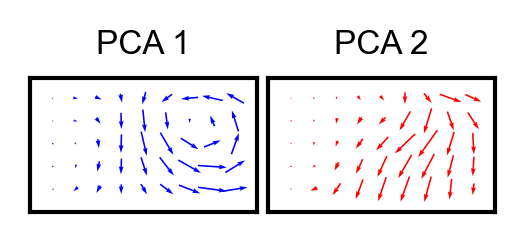

In [73]:
from utils.plot_utils import plot_vector2D

plt.style.use('Figure1/Figure1.mplstyle')
model, df = get_decomposition_results(vel_dataset, overwrite=False)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = [-15, 0, 20]

kwargs = dict(skip=20, width=0.007)

z = model['masker'].inverse_transform(model['svd'].components_)
z = z * np.sqrt(model['svd'].explained_variance_[:, None, None, None])

fig, ax = plt.subplots(1, 2, figsize=(2, 1))

plot_vector2D(ax[0], z[0], color='blue', **kwargs)
plot_vector2D(ax[1], z[1], color='red', **kwargs)

ax[0].set_title('PCA 1')
ax[1].set_title('PCA 2')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('Figure1/velocity_components')

Found SVDPipeline for this dataset!


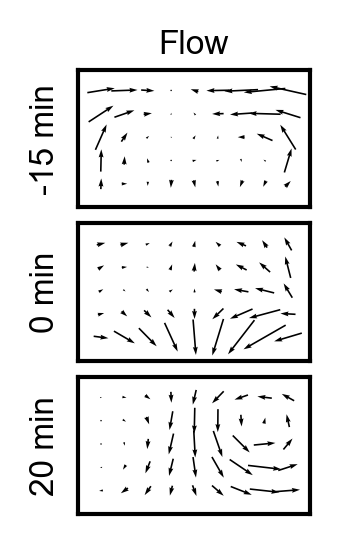

In [74]:
from utils.plot_utils import plot_vector2D
plt.style.use('Figure1/Figure1.mplstyle')

model, df = get_decomposition_results(vel_dataset, overwrite=False)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = [-15, 0, 20]

kwargs = dict(skip=20, width=0.007)

fig, ax = plt.subplots(3, 1, figsize=(1, 2.))

for i in range(len(t)):
    row = (data.t - t[i]).abs().argmin()
    row = data.iloc[row].filter(like='param').values
    z = model.inverse_transform(row[None])[0]
    plot_vector2D(ax[i], z, **kwargs)


ax[0].set_xlabel('Flow')
    
for i in range(3):
    ax[i].set_ylabel('%d min' % t[i])
    ax[i].xaxis.set_label_position('top')
                            
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig('Figure1/velocity_time')

Found SVDPipeline for this dataset!


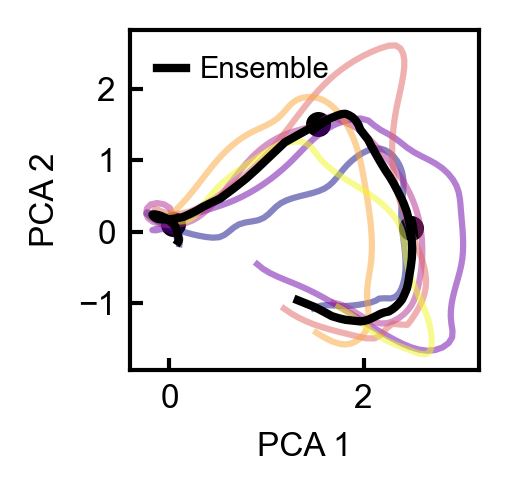

In [75]:
from scipy.interpolate import splprep, splev

plt.style.use('Figure1/Figure1.mplstyle')

model, df = get_decomposition_results(vel_dataset, overwrite=False)
tmin, tmax = -15, 45
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))
for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.01)
    x, y, = splev(np.linspace(0, 1, 100), f)
    
    ax.plot(x, y, c=colors[i], alpha=0.5)

from scipy.interpolate import interp1d

#Plot ensemble
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

#Add timepoints
t = [-10, 10, 25]
ax.scatter(p0(t), p1(t), s=25, color='black')

ax.set(xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

fig.savefig('Figure1/velocity_trajectory')

## ML Forecasting

In [77]:
sqh = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True)
cad = AtlasDataset('WT', 'ECad-GFP', 'raw2D', 
                           transform=Compose([transform, 
                                              Smooth2D(sigma=7)]))
runt = AtlasDataset('WT', 'Runt', 'raw2D',
                            transform=Compose([transform, 
                                              Smooth2D(sigma=3)]))

100%|██████████| 6/6 [00:00<00:00, 618.83it/s]


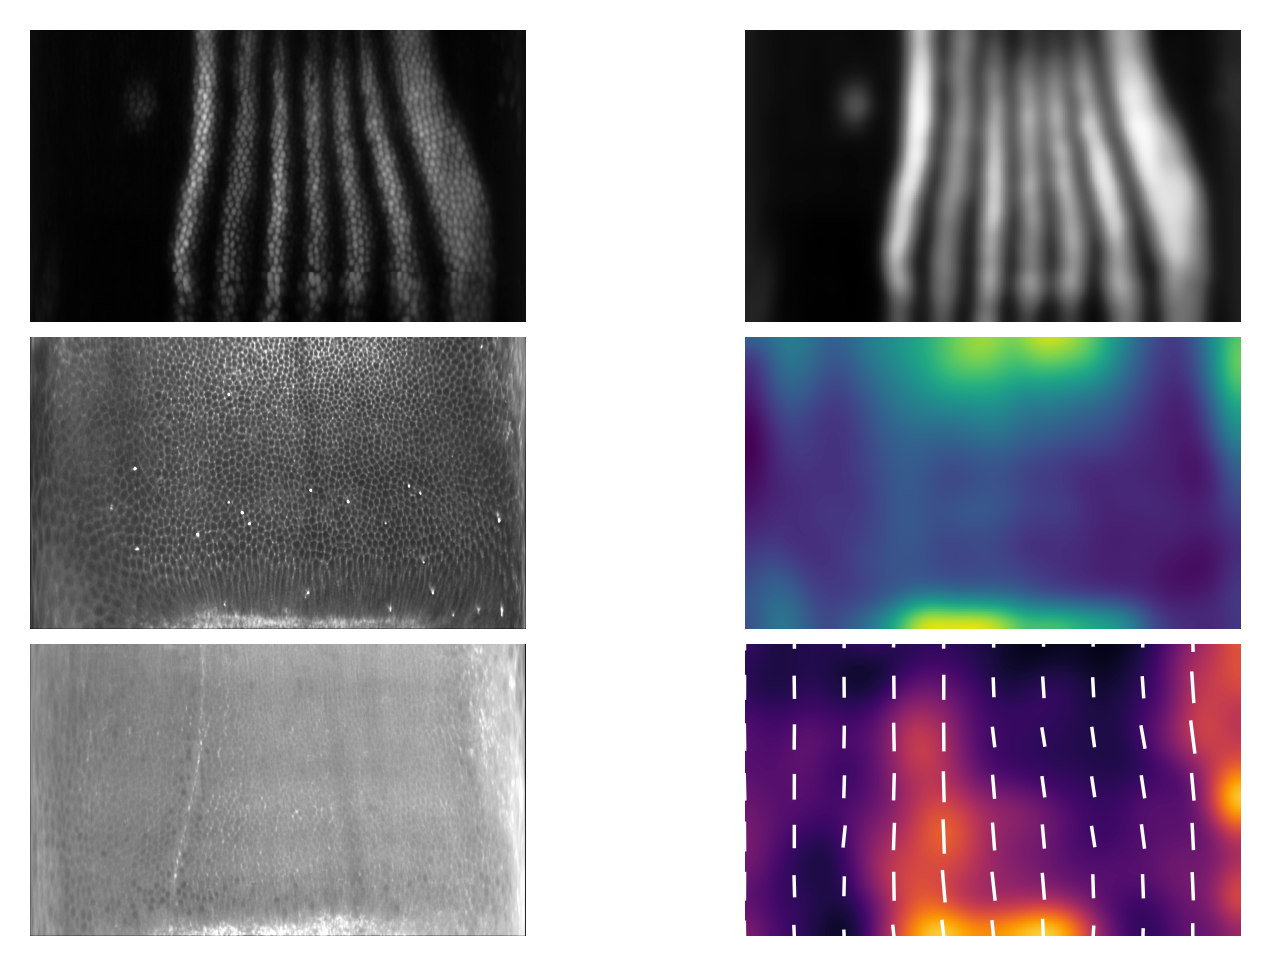

In [78]:
plt.style.use('Figure1/Figure1.mplstyle')
plt.rcParams['axes.linewidth'] = 0.

from PIL import Image
from utils.plot_utils import color_2D, plot_tensor2D

time = 0

cmap = ['Greys_r', 'viridis', 'inferno']

fig, ax = plt.subplots(3, 2, dpi=300)
for i, dataset in enumerate([runt, cad, sqh]):
    rows = dataset.df[np.abs(dataset.df.time - time) < 1]
    row = rows.iloc[2]
    proc = dataset[row.name]['value']
    tiff = os.path.join(row.folder, row.tiff)
    
    tiff = Image.open(tiff)
    tiff.seek(row.eIdx)
    
    color_2D(ax[i, 0], np.array(tiff)[None], cmap='Greys_r', vmin=np.min(tiff), vmax=np.min(tiff)+10*np.std(tiff))
    
    if proc.shape[0] == 4:
        plot_tensor2D(ax[i, 1], proc, cmap=cmap[i])
    else:
        color_2D(ax[i, 1], proc, cmap=cmap[i])
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
plt.savefig('Figure1/ML_Inputs')


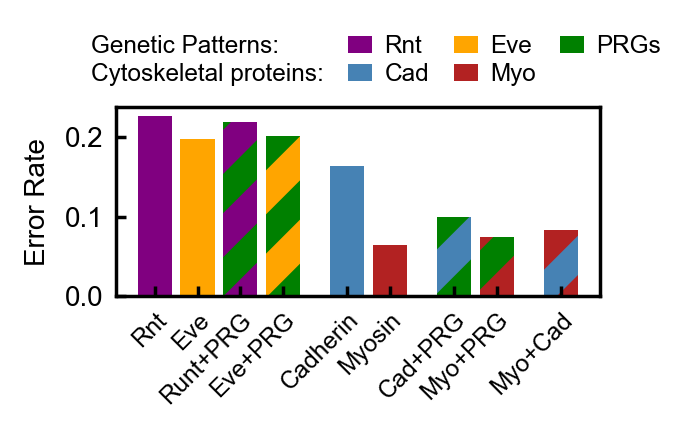

In [90]:
plt.style.use('Figure1/Figure1.mplstyle')

plt.rcParams['figure.frameon'] = True
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .2
plt.rcParams['legend.columnspacing'] = 1.

import matplotlib

logdir = '../../tb_logs'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver*LR')):
    info = torch.load(d, map_location='cpu')
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss']
    }, ignore_index=True)
data = data.sort_values('loss')
data = data.set_index('inputs')

#print(data)

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'PRG': 'green',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
ax.bar(len(labels)+offset, data.loss['Rnt'], facecolor=colors['Rnt'], label='Rnt')
labels.append('Rnt')

ax.bar(len(labels)+offset, data.loss['Eve'], facecolor=colors['Eve'], label='Eve')
labels.append('Eve')


idxs = [c for c in data.index if 'Rnt+' in c]
ax.bar(len(labels)+offset, data.loss[idxs].mean(),
       facecolor=colors['Rnt'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Runt+PRG')

idxs = [c for c in data.index if 'Eve+' in c]
ax.bar(len(labels)+offset, data.loss[idxs].mean(),
       facecolor=colors['Eve'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Eve+PRG')

offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], facecolor=colors['Cad'], label='Cad')
labels.append('Cadherin')
ax.bar(len(labels)+offset, data.loss['Sqh'], facecolor=colors['Sqh'], label='Myo')
labels.append('Myosin')

offset += 0.5
ax.bar(len(labels)+offset, data.loss[['Cad+Rnt', 'Cad+Eve']].mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Cad+PRG')
ax.bar(len(labels)+offset, data.loss[['Sqh+Rnt', 'Sqh+Eve']].mean()*1.2,
       facecolor=colors['Sqh'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Myo+PRG')
offset += 0.5
ax.bar(len(labels)+offset, data.loss['Sqh+Cad'], 
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+Cad')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=7, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')

blank = ax.plot([], marker="", ls="")[0]

h, l = ax.get_legend_handles_labels()
l = np.array(l).reshape([2, 2]).T.flatten().tolist()
h = np.array(h).reshape([2, 2]).T.flatten().tolist()

h.insert(0, blank)
l.insert(0, 'Genetic Patterns:')
h.insert(1, blank)
l.insert(1, 'Cytoskeletal proteins:')

from copy import copy
green = copy(h[-1])
green.set_facecolor(colors['PRG'])
h.append(green)
l.append('PRGs')

ax.legend(h, l, ncol=4,
          bbox_to_anchor=[0.5, 1],
          loc='lower center')

plt.savefig('Figure1/ForecastingAccuracy.png', dpi=350)

# Figure 2 - A search for sparsity

## Summary

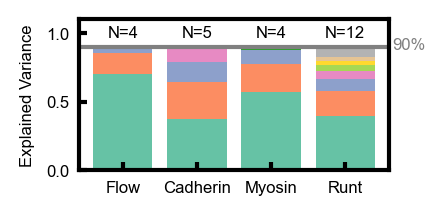

In [336]:
import pickle as pk
from sklearn.decomposition import PCA

plt.rcParams['font.size'] = 6
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.edgecolor'] = 'black'


basedir = 'Public/'

models = {
    'Flow': 'WT/ECad-GFP/decomposition_models/velocity_SVDPipeline.pkl',
    'Cadherin': 'WT/ECad-GFP/decomposition_models/cyt_SVDPipeline.pkl',
    'Myosin': 'Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/tensor_SVDPipeline.pkl',
    'Runt': 'WT/Runt/decomposition_models/raw_SVDPipeline.pkl',
    #'Eve': 'WT/Even_Skipped/decomposition_models/raw_SVDPipeline.pkl',
    #'Hst': 'WT/histone-RFP/decomposition_models/raw_SVDPipeline.pkl'
}
df = pd.DataFrame()
for i, key in enumerate(models.keys()):
    models[key] = pk.load(open(os.path.join(basedir, models[key]), 'rb'))
    try:
        evr = models[key].explained_variance_ratio_
    except:
        evr = models[key]['svd'].explained_variance_ratio_
    cum = np.cumsum(evr)
    dfi = pd.DataFrame({'explained_variance': evr, 'total_explained': cum})
    dfi['marker'] = key
    dfi['label'] = i
    df = df.append(dfi)
df = df.reset_index().rename({'index': 'component'}, axis=1)

fig = plt.figure(figsize=(2, 1))
ax = fig.gca()

colors = plt.cm.Set2(np.arange(df.component.max()))


for i in range(df.component.max()):
    dfi = df[(df.component == i) & (df.total_explained <= 0.9)]
    if len(dfi) == 0: continue
    ax.bar(
        dfi.label,
        dfi.explained_variance, 
        bottom=dfi.total_explained-dfi.explained_variance,
        color=colors[i],
    )
ax.axhline(0.9, color='grey', linestyle='-', zorder=1)
ax.text(1.01, 0.88, '90%', transform=ax.transAxes,
        color='grey', va='top', ha='left')
ax.set(yticks = [0, 0.5, 1], ylim=[0, 1.1], ylabel='Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set(
    xticks = df.label.unique(),
    xticklabels = df.marker.unique(),
)
for i in range(df.label.max()+1):
    dfi = df[(df.label == i)].reset_index(drop=True)
    dfn = dfi[dfi.total_explained >= 0.9]
    N = dfn.component.min()
    ax.bar(dfi.label[0], 0.9-dfi.total_explained[N-1], bottom=dfi.total_explained[N-1])
    ax.text(i, 0.95, 'N=%d'% (N+1), 
            va='bottom', ha='center')

plt.savefig('Figures/sparsity_summary.svg', bbox_inches='tight')

## Cadherin

In [34]:
from utils.dataset import *
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

transform = Reshape2DField()
pmg_cf_mask = np.load('Public/Masks/pmg_cf_mask.npy')
dynamic_mask = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
dynamic_time = np.load('Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
print(dynamic_mask.shape)
cell_size=7
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'raw2D', #'cyt2D', 
                           transform=Compose([transform, 
                                              Smooth2D(sigma=7)]))

(45, 236, 200)


100%|██████████| 6/6 [00:00<00:00, 525.87it/s]


Found SVDPipeline for this dataset!
(236, 200) (3, 1, 236, 200)
0.0 1.0
(236, 200)
0.0 1.0
(236, 200)
0.0 1.0
(236, 200)


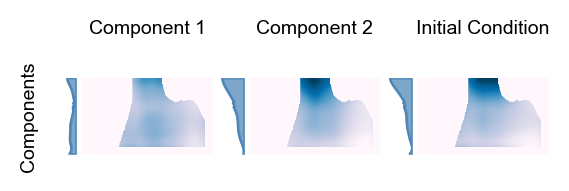

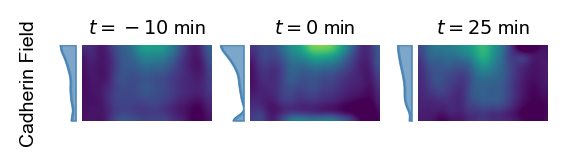

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['image.cmap'] = 'viridis'

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()
    
model, df = get_decomposition_results(
    cad_dataset,
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

eId = 'ensemble'
fname = 'raw2D.npy'# 'cyt2D.npy'
cad = np.load(
    os.path.join(cad_dataset.path, str(eId), fname),
    mmap_mode='r'
)
if eId == 'ensemble':
    t = np.load(
        os.path.join(cad_dataset.path, eId, 't.npy'),
        mmap_mode='r')
else:
    t = df[df.embryoID == eId].time.values
    
cad = LeftRightSymmetrize().fit_transform(cad)
    
vmax = np.median(cad) + 5 * np.std(cad)
vmin = np.median(cad) - 1 * np.std(cad)
cad = interp1d(t, cad, axis=0)
msk = interp1d(dynamic_time, dynamic_mask, axis=0, fill_value='extrapolate')


t = [-10, 0, 25]
N = len(t)
fig1, ax1 = plt.subplots(1, N, figsize=(N, 1))
fig2, ax2 = plt.subplots(1, N, figsize=(N, 1))

z = np.zeros([N, model['svd'].n_components])
z[0, 0] = 1
z[1, 1] = 1

#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='PuBu'
color='steelblue'

z = model.inverse_transform(z)

zmin = np.min(z[crop_mask])
zmax = np.max(z[crop_mask])

mask = model['masker'].mask_
print(mask.shape, z.shape)
zmin = np.min(z[..., mask])
zmax = np.max(z[..., mask])

pca_cuts, cad_cuts = [], []
for i in range(3):
    color_2D(ax1[i], z[i], cmap=cmap, vmin=zmin, vmax=zmax)
    
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 20, 60))

    cad_t = gaussian_filter(cad(t[i]), sigma=7)
    
    mask = msk(t[i]).astype(float)
    print(mask.min(), mask.max())
    mask[mask == 0] = 1.
    print(mask.shape)
    color_2D(ax2[i], cad_t, vmin=vmin, vmax=vmax, alpha=mask)
    #cad_cuts.append(get_DV_cut(cad_t, 100, 180))
    cad_cuts.append(get_DV_cut(cad_t, 100, 140))
        
    ax1[i].xaxis.set_label_position('top')
    ax2[i].xaxis.set_label_position('top')

    ax2[i].set_xlabel('$t = %d$ min' % (t[i])) 
    
pca_cuts = np.stack(pca_cuts)
cad_cuts = np.stack(cad_cuts)
for i in range(3):
    plot_cut(ax1[i], pca_cuts[i], pca_cuts.min(), pca_cuts.max(), color=color)
    plot_cut(ax2[i], cad_cuts[i], cad_cuts.min(), cad_cuts.max(), color=color)

    
lp=16
ax1[0].set_xlabel('Component 1', labelpad=lp)
ax1[1].set_xlabel('Component 2', labelpad=lp)
ax1[2].set_xlabel('Initial Condition', labelpad=lp)
ax1[0].set_ylabel('Components', labelpad=lp)

ax2[0].set_ylabel('Cadherin Field', labelpad=lp)  

fig1.subplots_adjust(wspace=0.3, hspace=0.05)
fig2.subplots_adjust(wspace=0.3, hspace=0.05)

fig1.savefig('Figures/cadherin_components.svg', bbox_inches='tight')
fig2.savefig('Figures/cadherin_time.svg', bbox_inches='tight')

Found SVDPipeline for this dataset!
-19.884 74.116


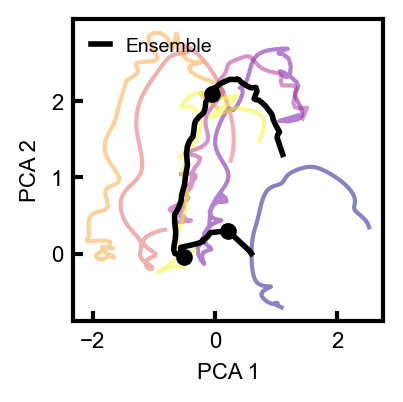

In [42]:
from scipy.interpolate import splprep, splev

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7

model, df = get_decomposition_results(
    cad_dataset,
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

tmin, tmax = -15, 45
print(df.t.min(), df.t.max())
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))
for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #x -= x.mean()
    #y -= y.mean()
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=0.1)#s=.2)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')
t = [-10, 0, 25]
ax.scatter(p0(t), p1(t), s=25, color='black', zorder=10)

ax.set(xticks=[-2, 0, 2], yticks=[0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

plt.savefig('Figures/cadherin_trajectory.svg', bbox_inches='tight')

## Myosin

In [73]:
from utils.dataset import *
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

transform = Reshape2DField()
pmg_cf_mask = np.load('Public/Masks/pmg_cf_mask.npy')

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 
                           'Sqh-GFP', 
                           'tensor2D', 
                           transform=transform)

100%|██████████| 1/1 [00:00<00:00, 422.56it/s]


Found SVDPipeline for this dataset!
(50, 4, 236, 200)


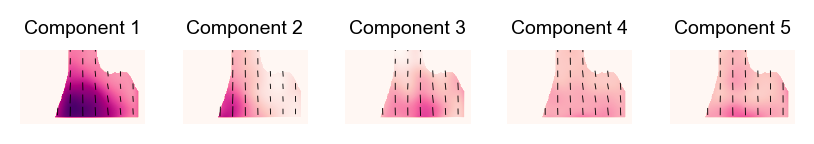

In [82]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['image.cmap'] = 'inferno'

model, df = get_decomposition_results(
    sqh_dataset, 
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

eId = 'ensemble'
sqh = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'tensor2D.npy'),
    mmap_mode='r'
)
sqh = sqh.reshape([sqh.shape[0], -1, *sqh.shape[-2:]])
if eId == 'ensemble':
    t = np.load(
        os.path.join(sqh_dataset.path, eId, 't.npy'),
        mmap_mode='r')
else:
    t = df[df.embryoID == eId].time.values

print(sqh.shape)
sqh_norm = np.linalg.norm(sqh, axis=(1, 2))
vmin = 0
vmax = np.std(sqh_norm)
sqh = interp1d(t, sqh, axis=0)


N = 5
fig1, ax1 = plt.subplots(1, N, figsize=(N, 1))

#Color maps
cmap='RdPu'
color='firebrick'

z = np.zeros([N, model['svd'].n_components])
for i in range(N):
    z[i, i] = 1

z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., model['masker'].mask_])
zmax = np.max(znorm[..., model['masker'].mask_])

for i in range(N):
    plot_tensor2D(ax1[i], z[i], cmap=cmap, 
                  linecolor='black', skip=20, 
                  vmin=zmin, vmax=zmax)
    ax1[i].set_title('Component %d' % (i+1))
fig1.subplots_adjust(wspace=0.3, hspace=0.05)


Found SVDPipeline for this dataset!
(50, 4, 236, 200)


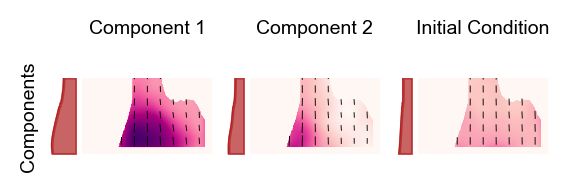

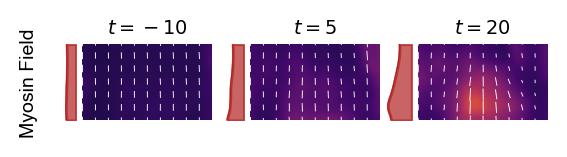

In [75]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 0.0
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['image.cmap'] = 'inferno'

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()
    

model, df = get_decomposition_results(
    sqh_dataset, 
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

eId = 'ensemble'
sqh = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'tensor2D.npy'),
    mmap_mode='r'
)
sqh = sqh.reshape([sqh.shape[0], -1, *sqh.shape[-2:]])
if eId == 'ensemble':
    t = np.load(
        os.path.join(sqh_dataset.path, eId, 't.npy'),
        mmap_mode='r')
else:
    t = df[df.embryoID == eId].time.values

print(sqh.shape)
sqh_norm = np.linalg.norm(sqh, axis=(1, 2))
vmin = 0
vmax = np.std(sqh_norm)
sqh = interp1d(t, sqh, axis=0)


t = [-10, 5, 20]
N = len(t)
skip = 20
fig1, ax1 = plt.subplots(1, N, figsize=(N, 1))
fig2, ax2 = plt.subplots(1, N, figsize=(N, 1))

#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='RdPu'
color='firebrick'

z = np.zeros([N, model['svd'].n_components])
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])

pca_cuts, sqh_cuts = [], []
for i in range(3):
    plot_tensor2D(ax1[i], z[i], cmap=cmap, 
                  linecolor='black', skip=20, 
                  vmin=zmin, vmax=zmax)
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 20, 60))

    sqh_t = sqh(t[i])
    plot_tensor2D(ax2[i], sqh_t, 
                  skip=20, 
                  vmin=vmin, vmax=vmax)
    sqh_cuts.append(get_DV_cut(sqh_t, 100, 180))
        
    ax1[i].xaxis.set_label_position('top')
    ax2[i].xaxis.set_label_position('top')

    ax2[i].set_xlabel('$t = %d$' % (t[i])) 
    
pca_cuts = np.stack(pca_cuts)
sqh_cuts = np.stack(sqh_cuts)
for i in range(3):
    plot_cut(ax1[i], pca_cuts[i], 0.2*pca_cuts.max(), pca_cuts.max(), color=color)
    plot_cut(ax2[i], sqh_cuts[i], 0, sqh_cuts.max(), color=color)

    
lp=16
ax1[0].set_xlabel('Component 1', labelpad=lp)
ax1[1].set_xlabel('Component 2', labelpad=lp)
ax1[2].set_xlabel('Initial Condition', labelpad=lp)
ax1[0].set_ylabel('Components', labelpad=lp)

ax2[0].set_ylabel('Myosin Field', labelpad=lp)  

fig1.subplots_adjust(wspace=0.3, hspace=0.05)
fig2.subplots_adjust(wspace=0.3, hspace=0.05)

fig1.savefig('Figures/myosin_components.svg', bbox_inches='tight')
fig2.savefig('Figures/myosin_time.svg', bbox_inches='tight')

Found SVDPipeline for this dataset!


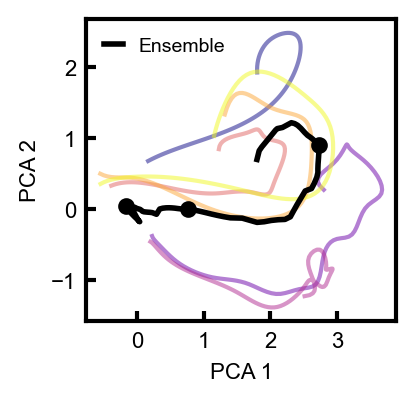

In [225]:
from scipy.interpolate import splprep, splev

plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'

model, df = get_decomposition_results(
    sqh_dataset,
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.05)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')
t = [-10, 5, 20]
ax.scatter(p0(t), p1(t), s=25, color='black', zorder=10)

ax.set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

plt.savefig('Figures/myosin_trajectory.svg', bbox_inches='tight')